In [2]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from my_func.Read_ibw import read_ibw

# SVDを全ての波長に対して行う関数
def apply_svd_to_all_wavenumbers(data, k):
    """
    データ全体に対してSVDを適用し、ノイズ除去を行う
    data: 4次元データ (x, y, z, wavelength)
    k: 上位k個の特異値を保持
    """
    # 1. データ全体 (151x201x波長範囲) に対してSVDを実行
    reshaped_data = data[:, :, 0, :].reshape(-1, data.shape[3])  # (x*y, wavelength) の2次元に変換
    U, S, Vt = svd(reshaped_data, full_matrices=False)

    # 2. 上位k個の特異値を使ってデータを再構築
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]
    S_k_matrix = np.diag(S_k)

    # 再構築
    reconstructed_data = np.dot(U, np.dot(S_k_matrix, Vt))

    # 再構築されたデータを元の形に戻す
    reconstructed_data = reconstructed_data.reshape(data[:, :, 0, :].shape)

    return reconstructed_data

# データの読み込み
data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
# 波長軸を最後の次元に移動
data = np.moveaxis(data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# 上位特異値の数を指定
k = 5

# SVDを全波長に対して適用
reconstructed_data = apply_svd_to_all_wavenumbers(data, k)


マスクされた点の数: 24397


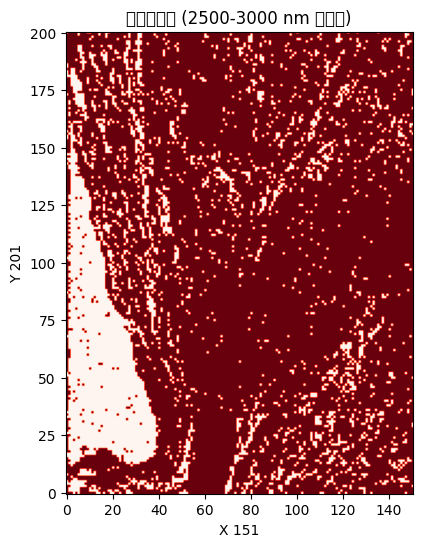

In [5]:
import numpy as np
from my_func.Read_ibw import read_ibw
import matplotlib.pyplot as plt

# データの読み込み
imchi3_data = reconstructed_data
# 波長軸を最後の次元に移動


# 波長データの読み込み
wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# 波長範囲の設定
min_wavelength = 2500  # 最小波長（nm）
max_wavelength = 3000  # 最大波長（nm）

# 波長範囲に対応するインデックスを取得
wavelength_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))[0]

# 強度の総和を計算（指定した波長範囲のみ）
# 強度の総和を計算（指定した波長範囲のみ）
intensity_sum = np.sum(imchi3_data[:, :, wavelength_indices], axis=-1)


# 4. 閾値に基づくマスクの作成
threshold = 20  # データに応じて調整
mask = intensity_sum > threshold  # 形状: (151, 201, 1)

# マスクの形状を調整（z 軸を除去して2次元に）
if mask.shape[-1] == 1:
    mask_2d = mask[:, :, 0]
else:
    mask_2d = mask

# マスクされた点の数を出力
masked_points_count = np.sum(mask_2d)
print(f"マスクされた点の数: {masked_points_count}")

# マスク結果の表示
cmap = plt.cm.get_cmap('Reds')
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d.T, cmap=cmap, origin='lower')
plt.title(f'マスク結果 ({min_wavelength}-{max_wavelength} nm の範囲)')
plt.xlabel('X 151')
plt.ylabel('Y 201')
plt.show()


抽出された波長データの数: 36
抽出されたimchi3_dataの形状: (151, 201, 36)
マスクされた点の数: 24397


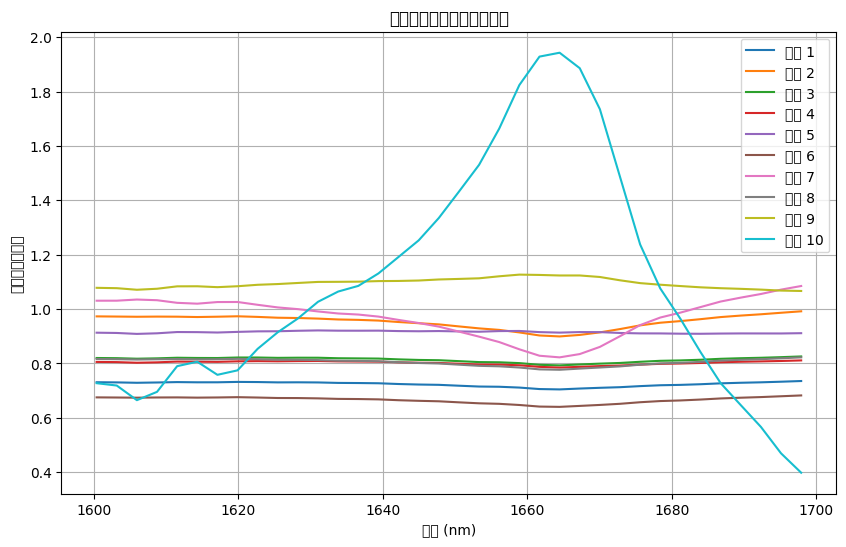

/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12500 (\N{KATAKANA LETTER PI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  f

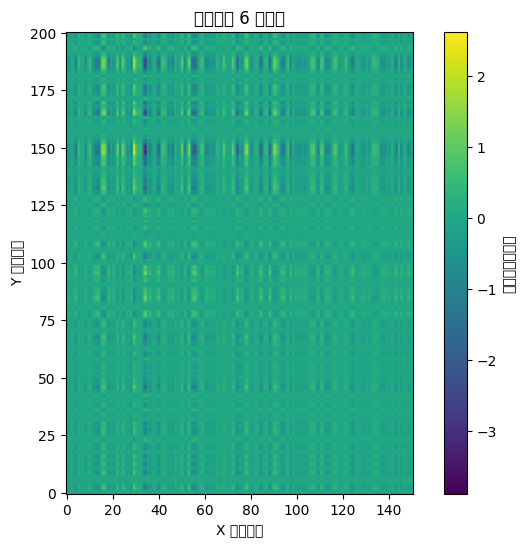

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from sklearn.preprocessing import StandardScaler
from my_func.Read_ibw import read_ibw


# 波長範囲の設定
min_wavelength = 1600  # 最小波長（nm）
max_wavelength = 1700  # 最大波長（nm）

# 波長範囲に対応するインデックスを取得
wavelength_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))[0]

# 対応する波長データの抽出
filtered_wavelengths = wavelengths[wavelength_indices]

# 対応するimchi3_dataの抽出（指定した波長範囲のみ）

filtered_imchi3_data = imchi3_data[:, :, wavelength_indices]  # 形状: (151, 201, 指定した波長範囲の数)


# 結果の確認
print(f"抽出された波長データの数: {filtered_wavelengths.shape[0]}")
print(f"抽出されたimchi3_dataの形状: {filtered_imchi3_data.shape}")

# テンソルライブラリのバックエンドを NumPy に設定
tl.set_backend('numpy')

# データの形状を確認

x_size, y_size, wavelength_size = filtered_imchi3_data.shape  # (151, 201, 波長の数)

# z 軸は存在しないため、ここでの処理は不要


# z 軸を除外（z_size = 1 のため不要）
x_size, y_size, wavelength_size = x_size, y_size, wavelength_size

# 空のテンソルを作成
tensor_data = np.zeros((x_size, y_size, wavelength_size))


# マスクの準備（マスクデータを既に持っている前提）
mask_2d = mask  # マスクは既に2次元のためそのまま使用
for x in range(x_size):
    for y in range(y_size):
        if mask_2d[x, y]:
            tensor_data[x, y, :] = filtered_imchi3_data[x, y, :]


# テンソルデータの標準化
tensor_data = (tensor_data - np.mean(tensor_data)) / np.std(tensor_data)

# 3. テンソル分解の実施

# ランクを設定
rank = 10 # データに応じて調整

# テンソル分解（CP分解）を実行
factors = parafac(tensor_data, rank=rank, init='random', tol=1e-6, n_iter_max=100)

# 因子行列を取得
weights = factors.weights          # 重み（ランク数）
factor_matrices = factors.factors  # 因子行列のリスト

# 各因子行列を取得
spatial_factor_x = factor_matrices[0]  # 形状: (x_size, rank)
spatial_factor_y = factor_matrices[1]  # 形状: (y_size, rank)
spectral_factor = factor_matrices[2]   # 形状: (wavelength_size, rank)

# マスクされた点の数を出力
masked_points_count = np.sum(mask_2d)
print(f"マスクされた点の数: {masked_points_count}")

# 5. スペクトル因子のプロット
plt.figure(figsize=(10, 6))
for r in range(rank):
    plt.plot(filtered_wavelengths, spectral_factor[:, r], label=f'因子 {r+1}')
plt.xlabel('波長 (nm)')
plt.ylabel('強度（相対値）')
plt.title('スペクトル因子のプロット')
plt.legend()
plt.grid(True)
plt.show()

# 6. 空間因子のプロット
# for r in range(rank):
    # 空間因子の外積を計算
r = 5
spatial_component = np.outer(spatial_factor_x[:, r], spatial_factor_y[:, r])
plt.figure(figsize=(8, 6))
plt.imshow(spatial_component.T, origin='lower', cmap='viridis')
plt.title(f'空間因子 {r+1} の分布')
plt.xlabel('X ピクセル')
plt.ylabel('Y ピクセル')
plt.colorbar(label='強度（相対値）')
plt.show()


/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20877 (\N{CJK UNIFIED IDEOGRAPH-518D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27083 (\N{CJK UNIFIED IDEOGRAPH-69CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from current font.
  fig.canva

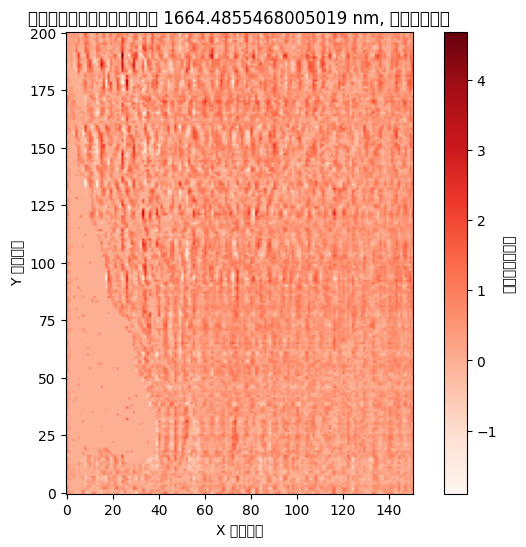

In [20]:
# 再構成テンソルの初期化
reconstructed_tensor = np.zeros_like(tensor_data)

# 各ランクごとの外積を計算して再構成
for r in range(rank):
    if r == 25: 
        continue
    spatial_component = np.outer(spatial_factor_x[:, r], spatial_factor_y[:, r])  # 空間因子の外積
    for w in range(wavelength_size):
        reconstructed_tensor[:, :, w] += weights[r] * spatial_component * spectral_factor[w, r]

# マスクを適用したテンソルのスライス
wavelength_index = np.argmin(np.abs(filtered_wavelengths - 1665))  

# マスクを適用したデータを再構成
masked_reconstructed_slice = np.zeros_like(reconstructed_tensor[:, :, wavelength_index])
masked_reconstructed_slice[mask_2d] = reconstructed_tensor[:, :, wavelength_index][mask_2d]

# 再構成されたデータ（マスク適用後）の表示
plt.figure(figsize=(8, 6))
plt.imshow(masked_reconstructed_slice.T, cmap='Reds', origin='lower')
plt.title(f'再構成されたイメージ（波長 {filtered_wavelengths[wavelength_index]} nm, マスク適用）')
plt.xlabel('X ピクセル')
plt.ylabel('Y ピクセル')
plt.colorbar(label='強度（相対値）')
plt.show()


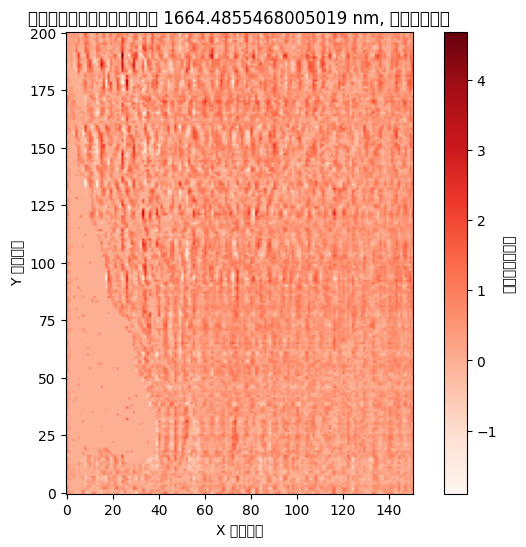

In [21]:
# 再構成テンソルの初期化
reconstructed_tensor = np.zeros_like(tensor_data)

# 各ランクごとの外積を計算して再構成
for r in range(rank):
  
    spatial_component = np.outer(spatial_factor_x[:, r], spatial_factor_y[:, r])  # 空間因子の外積
    for w in range(wavelength_size):
        reconstructed_tensor[:, :, w] += weights[r] * spatial_component * spectral_factor[w, r]

# マスクを適用したテンソルのスライス
wavelength_index = np.argmin(np.abs(filtered_wavelengths - 1665))  

# マスクを適用したデータを再構成
masked_reconstructed_slice = np.zeros_like(reconstructed_tensor[:, :, wavelength_index])
masked_reconstructed_slice[mask_2d] = reconstructed_tensor[:, :, wavelength_index][mask_2d]

# 再構成されたデータ（マスク適用後）の表示
plt.figure(figsize=(8, 6))
plt.imshow(masked_reconstructed_slice.T, cmap='Reds', origin='lower')
plt.title(f'再構成されたイメージ（波長 {filtered_wavelengths[wavelength_index]} nm, マスク適用）')
plt.xlabel('X ピクセル')
plt.ylabel('Y ピクセル')
plt.colorbar(label='強度（相対値）')
plt.show()


/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23492 (\N{CJK UNIFIED IDEOGRAPH-5BC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


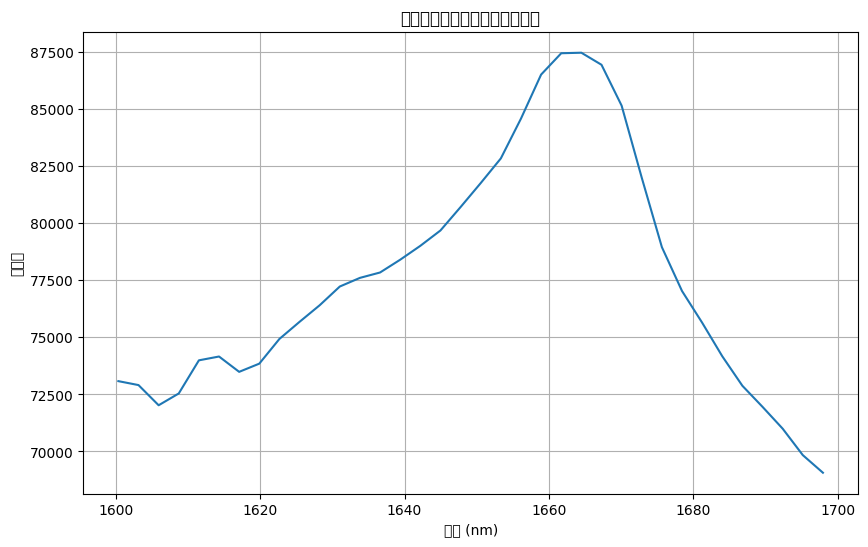

In [22]:
# 寄与率の計算
total_contribution = np.zeros(wavelength_size)

for r in range(rank):
    spatial_component = np.outer(spatial_factor_x[:, r], spatial_factor_y[:, r])  # 空間因子の外積
    for w in range(wavelength_size):
        contribution = weights[r] * spatial_component * spectral_factor[w, r]
        total_contribution[w] += np.sum(np.abs(contribution))  # 寄与率の絶対値の合計を計算

# 寄与率をプロット
plt.figure(figsize=(10, 6))
plt.plot(filtered_wavelengths, total_contribution)
plt.xlabel('波長 (nm)')
plt.ylabel('寄与率')
plt.title('ランクごとのスペクトル寄与率')
plt.grid(True)
plt.show()


/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35492 (\N{CJK UNIFIED IDEOGRAPH-8AA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


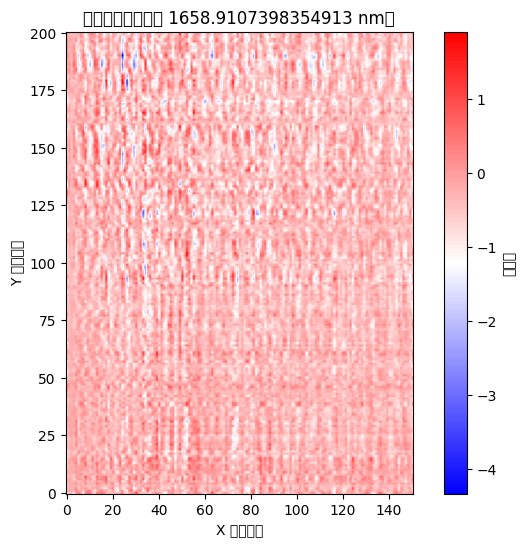

In [23]:
imchi3_data_squeezed = np.squeeze(imchi3_data)
# 波長範囲に対応するデータを抽出
imchi3_data_filtered = imchi3_data_squeezed[:, :, wavelength_indices]  

# 元データと再構成データの誤差を計算
error_tensor = imchi3_data_filtered - reconstructed_tensor

# 特定の波長スライスの誤差を可視化
wavelength_index = np.argmin(np.abs(filtered_wavelengths - 1660))  # 例として1660nm
plt.figure(figsize=(8, 6))
plt.imshow(error_tensor[:, :, wavelength_index].T, cmap='bwr', origin='lower')  # 青-赤でエラーを可視化
plt.title(f'再構成誤差（波長 {filtered_wavelengths[wavelength_index]} nm）')
plt.xlabel('X ピクセル')
plt.ylabel('Y ピクセル')
plt.colorbar(label='強度差')
plt.show()


/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12372 (\N{HIRAGANA LETTER GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(by

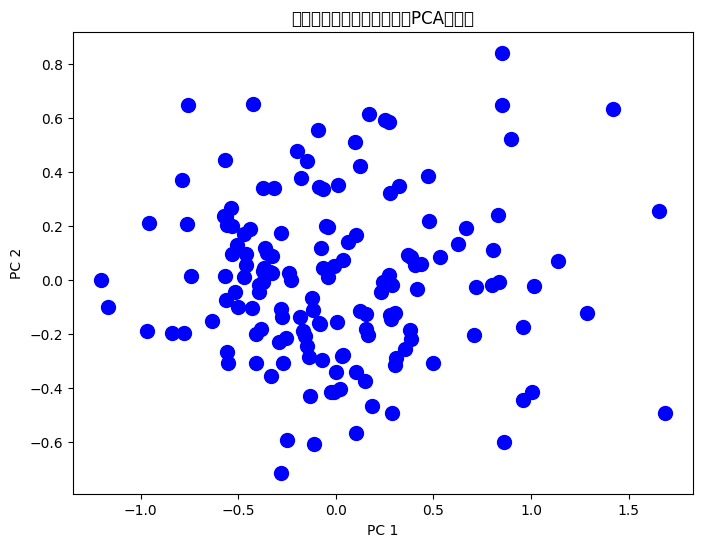

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# 空間因子をフラットにしてPCAを実施
flat_spatial_factors = spatial_factor_x.reshape(-1, rank)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_spatial_factors)

# PCA結果をプロット（ここでは 'c' を単一の色に設定）
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='b', s=100)  # ここで 'c' を青色 ('b') に指定
plt.title('ランクごとの主成分分析（PCA）結果')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12372 (\N{HIRAGANA LETTER GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gui/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(by

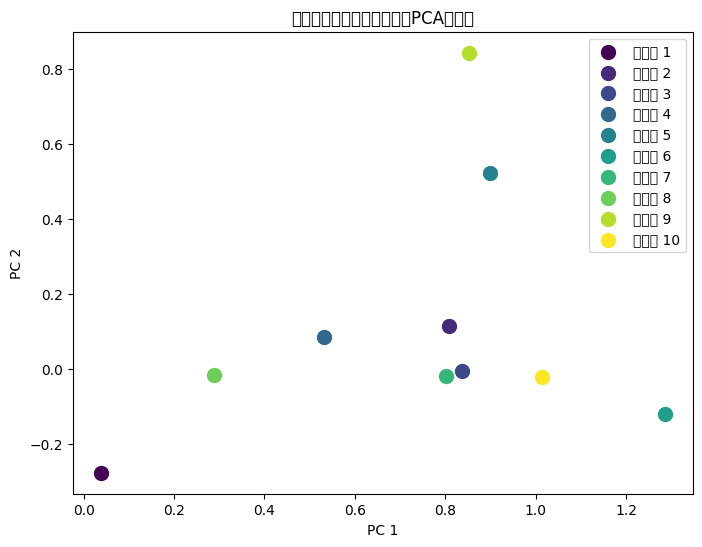

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import cm

# PCA結果を取得
flat_spatial_factors = spatial_factor_x.reshape(-1, rank)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_spatial_factors)

# カラーマップを使用してランクごとに色を割り当てる
colors = cm.viridis(np.linspace(0, 1, rank))

# PCA結果をプロット
plt.figure(figsize=(8, 6))
for r in range(rank):
    plt.scatter(pca_result[r, 0], pca_result[r, 1], color=colors[r], label=f'ランク {r+1}', s=100)

plt.title('ランクごとの主成分分析（PCA）結果')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
